<a href="https://colab.research.google.com/github/Base-R-Best-R/Auction/blob/main/Code/Models/Colab/RF_Train_Sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF in Sklearn

In [160]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error


# gdrive
from google.colab import drive
drive.mount("/content/drive")

## prel. for reading and writing pickle ##

# write
def save_object(obj, filename):
    with open(filename, "wb") as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# read
def load_object(filename):
    with open(filename, "rb") as inp:
        return pickle.load(inp)

Mounted at /content/drive


In [111]:
#  file names
nom = ["dat_aucs_feateng.csv", "Test_ind.csv", "Train_ind.csv"]
df_lst = []

for i in range(len(nom)):
  df_lst.append(pd.read_csv("drive/MyDrive/Colab Transfer/" + nom[i]))

# split
df = df_lst[0]

In [112]:
## one-hot-encoding ##

# year and month to str
df.Letting_Month = "M" + df.Letting_Month.astype("str")
df.Letting_Year = "Y" + df.Letting_Year.astype("str")
df.Winning_Bid = df.Winning_Bid / 1e3
df.Eng_Est = df.Eng_Est / 1e3

# remove variables that we will not use in our model
df.drop(["EW_Diff", "MLOT", "Contract_ID"], inplace = True, axis = 1)

# one-hot-matrix
oh_mat = pd.get_dummies(df)

# remove rowname col
oh_mat.drop(columns = oh_mat.columns[0], inplace = True)

# remove orig df from import list
df_lst.pop(0)

# dict
store_dct = {"Test": np.nan,
             "Train": np.nan}
sk = ["Test", "Train"]

# split into train and test
for i, ind in enumerate(df_lst):

  store_dct[sk[i]] = oh_mat.iloc[np.array(ind).reshape(-1) - 1]


In [114]:
## prep model input ##
dep = [np.nan, np.nan]
feat = [np.nan, np.nan]
nom = [np.nan, np.nan]

for i, df in enumerate(store_dct):

  # dep. var.
  dep[i] = np.array(store_dct[df].Winning_Bid)

  # features rm W_bid
  store_dct[df] = store_dct[df].drop("Winning_Bid", axis = 1)

  # safe column names
  nom[i] = list(store_dct[df].columns)

  # to np array
  feat[i] = np.array(store_dct[df])

# Random Forest CV


In [ ]:
## Model (1 - train, 0 - test)##

# set method
rf = RandomForestRegressor(random_state = 33)

# display possible inputs
pprint(rf.get_params())

# build tuning grid
tgrid = {
 'criterion': ['squared_error'],
 'max_depth': np.append([int(x) for x in np.linspace(10, 110, num = 11)], 200),
 'max_features': np.append([int(x) for x in np.linspace(10, 110, num = 11)], [500, 800, 1000,1100]),
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
}

In [116]:
# CV settings
rf_CV_rand = RandomizedSearchCV(estimator = rf, param_distributions = tgrid, 
                           n_iter = 200, cv = 5, verbose = 2, random_state = 33, n_jobs = -1)

# train
rf_CV_rand.fit(feat[1], dep[1])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=33),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 200]),
                                        'max_features': array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        500,  800, 1000, 1100]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=33, verbose=2)

In [119]:
# view best params
print(rf_CV_rand.best_params_)

# view best estimate
print(rf_CV_rand.best_score_)

# save 
# save_object(rf_CV_rand, "drive/MyDrive/Master_Thesis/Models_MT/RF_CV_rand.pkl")

{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1100, 'max_depth': 20, 'criterion': 'squared_error'}
0.9040695589843452


RMSE: 252502.93567465886
Alt_RMSE: 252502.93567465886
Dif_Ac_EngEst: 247065.33632427835


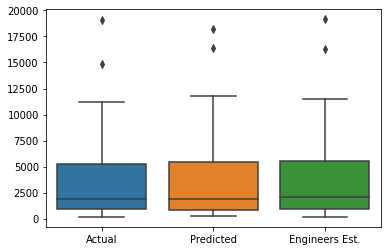

In [158]:
# read back CV object of Rf
rf_CV_rand = load_object("drive/MyDrive/Master_Thesis/Models_MT/RF_CV_rand.pkl")

# predict
w_bid_pred = rf_CV_rand.predict(feat[0])

# plot prelim.
plot_df = pd.DataFrame({"Actual": dep[0],
                        "Predicted": w_bid_pred,
                        "Engineers Est.": feat[0][:, 2]})

# performance eval.
sns.boxplot(data = plot_df[["Actual", "Predicted", "Engineers Est."]])

# mean squared error
print("RMSE:", mean_squared_error(dep[0], w_bid_pred, squared = True))
print("Dif_Ac_EngEst:", mean_squared_error(dep[0], plot_df["Engineers Est."]))

# First Evaluation

Given that the training error is significantly lower than the test error, we may suspect that the model in its current state contains too many variables carrying the same information. Accordingly, next we may use feature selection methods to determin the variables we use to refit the model.

In [187]:
## feature selection ##
selecta = SelectFromModel(rf)

# fit 
selecta.fit(feat[1], dep[1])
rf.fit(feat[1], dep[1]) # default value for n_estimators (trees) chosen, prob. few trees!

# features which importance is greater than the mean importance (we may change the treshold at a later stage)
sel_supp = selecta.get_support()

# selected features
sel_names = store_dct["Train"].columns[sel_supp]
print(sel_names)

Index(['Contract_Time', 'N_Firm', 'Eng_Est', 'Vend_884A', 'Vend_232A',
       'Vend_801A', 'Vend_099H', 'overlay', 'pave', 'drainag', 'interst',
       'reclam', 'landscap', 'Vend_884A_x_Vend_870A', 'Vend_884A_x_Vend_099H',
       'Vend_854A_x_Vend_090A', 'Vend_090A_x_Vend_099H',
       'Vend_801A_x_Vend_099H', 'County_ADAMS', 'Letting_Year_Y2018'],
      dtype='object')


In [188]:
# unmount gdrive
drive.flush_and_unmount()